# Redes Adversárias Generativas (GANs)

https://keras.io/api/datasets/mnist/

In [1]:
import tensorflow as tf
tf.__version__

'2.13.0-rc2'

In [3]:
import ssl
ssl._create_default_https_context = ssl._create_stdlib_context

In [1]:
import os
import glob #gerar gif
import imageio #gerar gif
import matplotlib.pyplot as plt 
import numpy as np 
import PIL # manipular imagens
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Dense, BatchNormalization
from keras.models import Sequential
import time

from IPython import display

In [4]:
# subindo a base 
(train_images, train_labels), (_,_) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


In [5]:
# defifindo o tamanho da imagem e 1 corresponde a perfil de cores grayscale
train_images = train_images.reshape(train_images.shape[0],28,28,1).astype('float32') 
train_images = (train_images - 127.5) / 127.5 #normalizando a imagem para -1, 1

In [6]:
BUFFER_SIZE = 60000 #tamanho do conjunto de dados
BATCH_SIZE = 256 # variação de pixels

In [7]:
# criando a base de treinamento
# from_tensor_slices: imagens dentro de um tensor 
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [13]:
# criando o nosso modelo gerador

def make_generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7,7,256)))
  assert model.output_shape == (None, 7, 7, 256)

  model.add(layers.Conv2DTranspose(128,(5, 5), strides=(1,1), padding='same', use_bias=False))
  assert model.output_shape == (None, 7, 7, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64,(5, 5), strides=(2,2), padding='same', use_bias=False))
  assert model.output_shape == (None, 14, 14, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1,(5, 5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 28, 28, 1)

  return model

A rede geradora cria uma imagem extraindo características de imagens reais e a outra rede julga se essa imagem é real ou não 

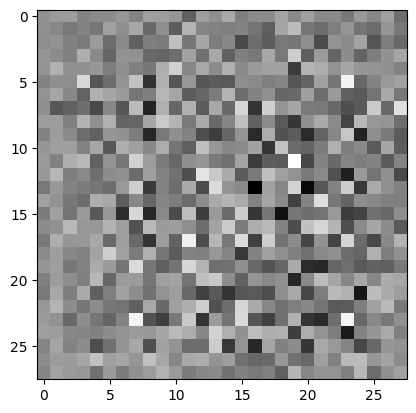

In [14]:
# criando ruído aleatório, a partir dele a imagem será criada
generator = make_generator_model()

noise = tf.random.normal([1,100])
generator_image = generator(noise, training=False)

plt.imshow(generator_image[0, :, :, 0], cmap='gray')

In [15]:
# criando a rede validadora 
# rede convolucional 
def make_discriminator_model():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (5, 5), strides=(2,2), padding='same', input_shape=[28,28,1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, (5, 5), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  return model

In [16]:
discriminator = make_discriminator_model()
decision = discriminator(generator_image) # valor positivo = imagem real
print(decision)

tf.Tensor([[0.00081601]], shape=(1, 1), dtype=float32)


In [17]:
# loss function
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [18]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output) # dado real 1 = verdadeiro
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output) # dado fake 0 = falso
    total_loss = real_loss + fake_loss 
    return total_loss

In [19]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output) # só dados falsos

In [21]:
from keras.optimizers.legacy import Adam

In [24]:
# função de custo Adam
generator_optimizer = tf.keras.optimizers.legacy.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.legacy.Adam(1e-4)

In [25]:
# para salvar o modelo
checkpoint_dir = './training_checkpoints' #diretório para salvar pontos específicos de rede
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                               discriminator_optimizer=discriminator_optimizer,
                                generator=generator,
                                discriminator=discriminator)

In [26]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [31]:
def train_step(images): # recebe as imagens
  noiose = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generate_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generate_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradientes_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradientes_of_discriminator, discriminator.trainable_variables))

In [32]:
# criando a função de treino da rede
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

      # cria o gif
      display.clear_output(wait=True)
      generate_and_save_images = (generator,
                                  epoch + 1,
                                  seed)

      # salva o modelo a cada 15 épocas de procesamento
      if(epoch + 1) % 15 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

      print('Tempo para a época {} é {} sec'.format(epoch + 1, time.time()-start))

    # gerador após a época final
    display.clear_output(wait=True)
    generate_and_save_images = (generator,
                                  epoch + 1,
                                  seed)

In [33]:
# função de definição das imagens
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

  plt.savefig('imagem_epoch_{:04d}.png'.fomrat(epoch))
  plt.show

In [34]:
# treinando 
train(train_dataset, EPOCHS)

Tempo para a época 50 é 25.899024963378906 sec
